# CS 4993 Independent Study – Machine Learning with COVID Data

***Professor: [Haiyang Shen](https://engineering.virginia.edu/faculty/haiying-shen)***  
***Researcher: [Iain Muir](https://www.linkedin.com/in/iain-muir-b37718164/) | iam9ez***

*Github Project:* https://github.com/iainmuir6/machineLearning_covidData

*Last Updated: June 6th, 2021*

References
* [CS 4774 ML Material – Professor Rich Nguyen](https://www.cs.virginia.edu/~nn4pj/teaching)
* [Steps to Building Machine Learning Model](https://analyticsindiamag.com/the-7-key-steps-to-build-your-machine-learning-model/)
* [Steps to Data Preprocessing](https://hackernoon.com/what-steps-should-one-take-while-doing-data-preprocessing-502c993e1caa)
* [Handling Missing Values](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)
* [Feature Selection I](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
* [Feature Selection II](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [Keras Neural Network I](https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3)

#### TODO List
* Loop through models, incrementally changing nodes/layers
* Run Models with Generated Data
    * Look more into GAN
* Convolution, Pooling, Recurrent, etc. Layers?
* Variety of Deep Learning Models
    * Organize Models by Performance
    
Consider...
* Alternative method for handling missing values

## 0. Import Packages

#### 0.1 General Imports

In [82]:
from IPython.display import Markdown, display
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from matplotlib import cm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import random

#### 0.2 ML Imports

In [115]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn

from keras.layers import Dense, LeakyReLU, PReLU, BatchNormalization, Activation, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from tensorflow import keras
import tensorflow as tf

In [3]:
tf.__version__

'2.3.0'

In [103]:
keras.__version__

'2.4.0'

In [108]:
sklearn.__version__

'0.23.1'

In [5]:
SEED = 42

## 1. Read Excel File

#### 1.1 Data Overview

In [6]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()
df.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [7]:
df.shape

(7380, 41)

In [8]:
target = 'COVIDResult'
df.columns

Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')

###### Column Description
Note (src - [Walk-In-Lab](https://www.walkinlab.com/products/view/complete-blood-count-cbc-comprehensive-metabolic-panel-cmp-14-blood-test-panel#:~:text=A%20CBC%20also%20helps%20your,anemia%2C%20and%20several%20other%20disorders.&text=Comprehensive%20Metabolic%20Panel%20)): 

CBC == [Complete Blood Count](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Complete Blood Count (CBC) gives important information about the numbers and kinds of cells in the blood, especially red blood cells, white blood cells, and platelets. A CBC helps your health professional check any symptoms, such as fatigue, weakness, or bruising, that you may have. A CBC also helps your health professional diagnose conditions, such as infection, anemia, and several other disorders.

CMP == [Comprehensive Metabolic Panel](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/113631)
* Comprehensive Metabolic Panel (CMP-14) with eGFR is a group of 14 laboratory tests ordered to give information about the current status of your liver, kidneys, and electrolyte and acid/base balance.  The test gives the current status of your blood sugar and blood proteins also.

#### 1.2 Descriptive Statistics

In [9]:
df.info()
target = 'COVIDResult'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [10]:
df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [11]:
df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [12]:
print(df[target].value_counts())

None Detected    6910
Detected          470
Name: COVIDResult, dtype: int64


#### 1.3 Inspect Null Data

In [13]:
print('Total Number of NULL Data Points:', df.isnull().sum().sum())
df.isnull().sum()

Total Number of NULL Data Points: 69411


index                          0
patno                          0
Admitted                       0
AdmittingDepartment         4377
COVIDResult                    0
Age                            0
FirstRace                      1
Ethnicity                      0
Sex                            0
heart_rate                    28
sbp                           88
dbp                           88
pulse_ox                      34
resp_rate                     68
height                      6924
wght                        4132
cbc_wbc                     1124
cbc_hematocrit              1124
cbc_hemoglobin              1123
cbc_platelets               1124
cbc_neutrophil_c            3507
cbc_eosinophil_perc         3508
cbc_lymphocyte_c            3506
cbc_lymphocyte_perc         3506
cbc_eosinophil_c            3508
cbc_eosinophil_perc.1       3508
cbc_monocyte_c              3506
cbc_eosinophil_perc.2       3508
cmp_sodium                  1094
cmp_potassium               1810
cmp_chlori

In [14]:
d = {
    col: round(df[col].isnull().sum() * 100 / len(df[col]), 4)
    for col in df
}
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
majority_null = [k for k, v in d.items() if v > 50.0]

# print("Null Data Points by variable")
# d

<AxesSubplot:>

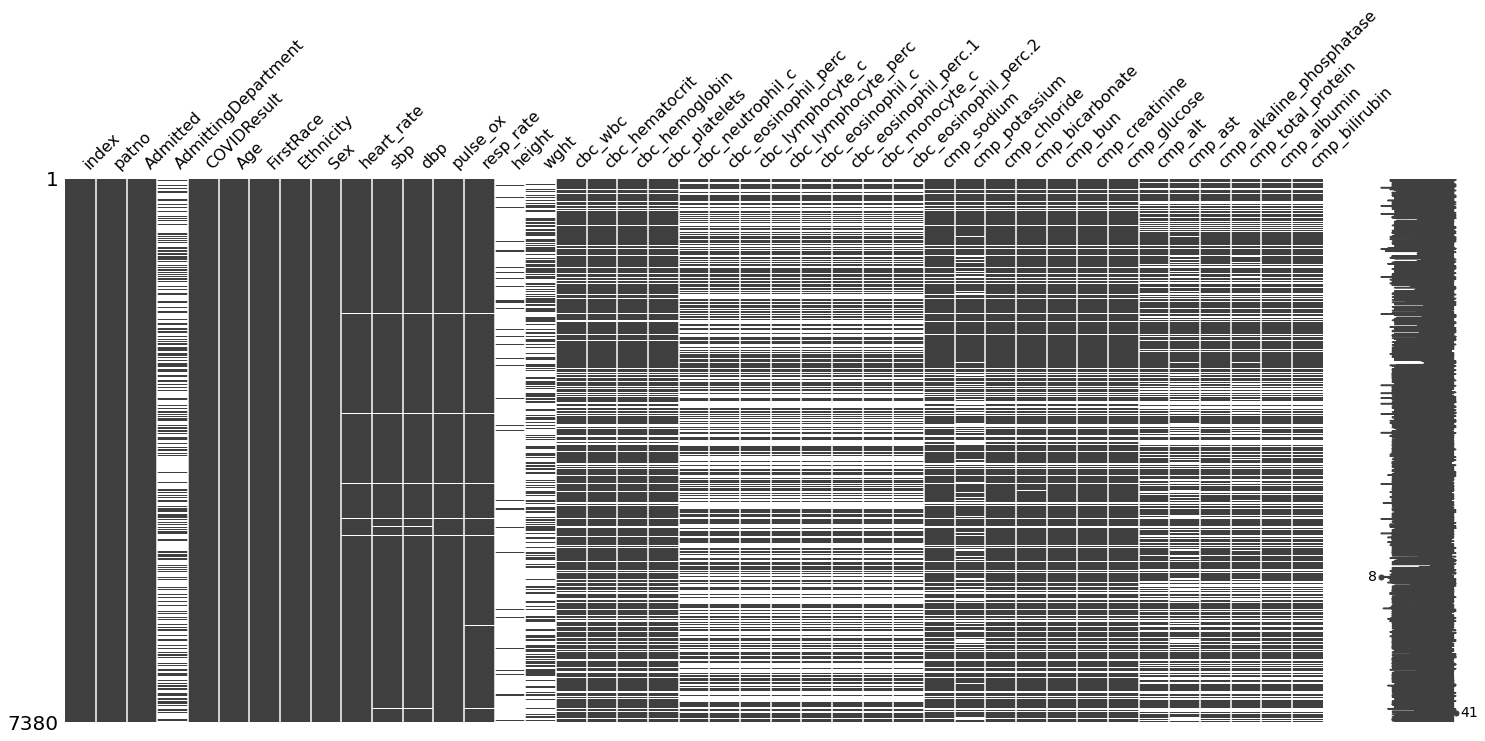

In [15]:
msno.matrix(df)
# msno.heatmap(df)

## 2. Data Preparation

#### 2.1 Drop Columns

In [16]:
trim_df = df.drop(columns=majority_null)
trim_df = trim_df.drop(columns=['index', 'patno'])
trim_df.head(5)

,Admitted,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,dbp,pulse_ox,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,82.0,96.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,88.0,98.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,0,None Detected,55,African American,Non-Hispanic,Male,83.0,152.0,76.0,98.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,65.0,87.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,0,None Detected,67,African American,Non-Hispanic,Female,90.0,128.0,69.0,98.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [17]:
trim_df.isnull().sum().sum()

53978

#### 2.2 Handle Categorical Variables

In [18]:
trim_df.select_dtypes(include=['object']).columns

Index(['COVIDResult', 'FirstRace', 'Ethnicity', 'Sex', 'cmp_bicarbonate',
       'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'],
      dtype='object')

###### 2.2.1 Manual Conversion

In [19]:
cat_cols = [
    'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'
]
less_than_list = [
    '<5', '<2', '<0.2', '<6', '<0.1'
]


def replace_cat(val, less, num):
    if val == less:
        return random.uniform(0, num) if "." in less else random.randint(0, num)
    else:
        return float(val)

    
trim_df2 = trim_df.copy()
for col, less_than in zip(cat_cols, less_than_list):
    upper_range = float(less_than[1:])
    trim_df2[col] = trim_df2[col].apply(lambda x: replace_cat(x, less_than, upper_range))

trim_df2.head(5)

,Admitted,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,dbp,pulse_ox,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,82.0,96.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,88.0,98.0,...,19.0,11.0,0.9,83.0,73.0,NaN,100.0,8.1,4.6,0.6
2,0,None Detected,55,African American,Non-Hispanic,Male,83.0,152.0,76.0,98.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,65.0,87.0,...,30.0,45.0,1.6,297.0,22.0,NaN,78.0,7.8,3.7,0.5
4,0,None Detected,67,African American,Non-Hispanic,Female,90.0,128.0,69.0,98.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [20]:
trim_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Admitted                  7380 non-null   int64  
 1   COVIDResult               7380 non-null   object 
 2   Age                       7380 non-null   int64  
 3   FirstRace                 7379 non-null   object 
 4   Ethnicity                 7380 non-null   object 
 5   Sex                       7380 non-null   object 
 6   heart_rate                7352 non-null   float64
 7   sbp                       7292 non-null   float64
 8   dbp                       7292 non-null   float64
 9   pulse_ox                  7346 non-null   float64
 10  resp_rate                 7312 non-null   float64
 11  cbc_wbc                   6256 non-null   float64
 12  cbc_hematocrit            6256 non-null   float64
 13  cbc_hemoglobin            6257 non-null   float64
 14  cbc_plat

###### 2.2.2 Encoding

In [21]:
cat_cols = [
    'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'
]

trim_df3 = trim_df2.copy()
for col in cat_cols:
    trim_df3[col] = trim_df3[col].fillna("Unspecified")
    enc = OrdinalEncoder()
    trim_df3[col + "_Encoded"] = enc.fit_transform(trim_df3[[col]])
trim_df3.head(5)

,Admitted,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,dbp,pulse_ox,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,82.0,96.0,...,14.0,26.0,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,88.0,98.0,...,73.0,NaN,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,None Detected,55,African American,Non-Hispanic,Male,83.0,152.0,76.0,98.0,...,26.0,29.0,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,65.0,87.0,...,22.0,NaN,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,None Detected,67,African American,Non-Hispanic,Female,90.0,128.0,69.0,98.0,...,12.0,18.0,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


###### 2.2.3 Categorical Codes

In [22]:
for col in cat_cols:
    display(Markdown("**{}**".format(col)))
    for each in trim_df3.groupby([col, col + '_Encoded']).indices:
        print(each)
    print()

**COVIDResult**

('Detected', 0.0)
('None Detected', 1.0)



**FirstRace**

('African American', 0.0)
('American Indian and Alaska Native', 1.0)
('Asian', 2.0)
('Hispanic', 3.0)
('Native Hawaiian and Other Pacific Islander', 4.0)
('Other', 5.0)
('Patient Refused', 6.0)
('Patient Unavailable', 7.0)
('Unspecified', 8.0)
('White or Caucasian', 9.0)



**Ethnicity**

('*Unspecified', 0.0)
('Hispanic', 1.0)
('Non-Hispanic', 2.0)
('Patient Refused', 3.0)
('Patient Unavailable', 4.0)



**Sex**

('Female', 0.0)
('Male', 1.0)
('Unknown', 2.0)



In [23]:
trim_df3 = trim_df3.drop(columns=['COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'])
trim_df3.head(5)

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,78,94.0,138.0,82.0,96.0,29.0,14.01,34.1,11.0,...,14.0,26.0,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,23,121.0,134.0,88.0,98.0,18.0,5.04,36.2,11.9,...,73.0,NaN,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,55,83.0,152.0,76.0,98.0,21.0,7.13,36.0,12.0,...,26.0,29.0,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,50,88.0,138.0,65.0,87.0,18.0,5.74,32.9,11.6,...,22.0,NaN,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,67,90.0,128.0,69.0,98.0,18.0,10.56,31.7,9.8,...,12.0,18.0,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


In [24]:
trim_df3.shape

(7380, 36)

In [25]:
trim_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Admitted                  7380 non-null   int64  
 1   Age                       7380 non-null   int64  
 2   heart_rate                7352 non-null   float64
 3   sbp                       7292 non-null   float64
 4   dbp                       7292 non-null   float64
 5   pulse_ox                  7346 non-null   float64
 6   resp_rate                 7312 non-null   float64
 7   cbc_wbc                   6256 non-null   float64
 8   cbc_hematocrit            6256 non-null   float64
 9   cbc_hemoglobin            6257 non-null   float64
 10  cbc_platelets             6256 non-null   float64
 11  cbc_neutrophil_c          3873 non-null   float64
 12  cbc_eosinophil_perc       3872 non-null   float64
 13  cbc_lymphocyte_c          3874 non-null   float64
 14  cbc_lymp

#### 2.3 Handle Missing Values

In [26]:
num_cols = [
    'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin',
    'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c',
    'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
    'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate',
    'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase',
    'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin'
]

trim_df4 = trim_df3.copy()
for col in num_cols:
    trim_df4[col] = trim_df4[col].replace(np.NaN, trim_df4[col].mean())
    
trim_df4.head(5)

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,78,94.0,138.0,82.0,96.0,29.0,14.01,34.1,11.0,...,14.0,26.000000,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,23,121.0,134.0,88.0,98.0,18.0,5.04,36.2,11.9,...,73.0,55.627858,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,55,83.0,152.0,76.0,98.0,21.0,7.13,36.0,12.0,...,26.0,29.000000,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,50,88.0,138.0,65.0,87.0,18.0,5.74,32.9,11.6,...,22.0,55.627858,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,67,90.0,128.0,69.0,98.0,18.0,10.56,31.7,9.8,...,12.0,18.000000,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


In [27]:
trim_df4.isnull().sum().sum()

0

#### 2.4 Feature Scaling

In [28]:
code_cols = [
    'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'COVIDResult_Encoded'
]

codes_df = trim_df4[code_cols]
trim_df5 = trim_df4.drop(columns=code_cols)

scaler = StandardScaler()
scaled = scaler.fit_transform(trim_df5)
scaled_df = pd.DataFrame(data=scaled, columns=trim_df5.columns)

In [29]:
merged_df = pd.concat([scaled_df, codes_df], axis=1)
merged_df.head(5)

,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,cbc_platelets,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,COVIDResult_Encoded
0,1.233730,-0.022731,0.073884,0.392190,-0.278428,1.184224,0.520132,-0.721388,-0.741784,0.616521,...,-0.239182,-0.443815,1.824984,0.917976,-0.234216,1,9.0,2.0,0.0,1.0
1,-1.104301,1.135743,-0.073763,0.786661,0.244608,-0.450035,-0.702405,-0.383468,-0.337826,0.722131,...,0.000000,-0.183931,1.258890,1.524718,-0.166295,0,9.0,2.0,0.0,1.0
2,0.256008,-0.494702,0.590651,-0.002281,0.244608,-0.004328,-0.417555,-0.415651,-0.292942,-0.091067,...,-0.214963,-0.105966,-0.156346,0.311233,-0.098374,0,0.0,2.0,1.0,1.0
3,0.043460,-0.280170,0.073884,-0.725478,-2.632085,-0.450035,-0.607001,-0.914485,-0.472478,-1.316144,...,0.000000,-0.469804,0.834319,-0.295509,-0.234216,1,9.0,2.0,1.0,1.0
4,0.766124,-0.194357,-0.295234,-0.462497,0.244608,-0.450035,0.049926,-1.107582,-1.280394,0.605960,...,-0.303765,0.101942,0.268225,-0.700004,-0.437977,0,0.0,2.0,0.0,1.0


#### 2.5 Train / Test Split

In [30]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)

#### 2.6 Final Prepared Data

In [31]:
final_data = merged_df.copy()
final_train = train.copy()
final_test = test.copy()
target = 'COVIDResult_Encoded'

In [32]:
final_data.shape

(7380, 36)

In [33]:
final_train.shape

(5904, 36)

In [34]:
final_test.shape

(1476, 36)

In [35]:
print(final_train[target].value_counts())
print(final_test[target].value_counts())

1.0    5543
0.0     361
Name: COVIDResult_Encoded, dtype: int64
1.0    1367
0.0     109
Name: COVIDResult_Encoded, dtype: int64


## 3. Feature Selection

In [36]:
X = final_data.loc[:, final_data.columns != target]
pos_X = trim_df4.loc[:, trim_df4.columns != target]
X_norm = MinMaxScaler().fit_transform(pos_X)
Y = final_data[target]

###### Number of Features

In [37]:
top_n_feats = 35

In [38]:
def plot_scores(scores, selector):
    plt.bar(range(len(scores)), scores, color='b')
    plt.show()

#### 3.1 Pearson Correlation

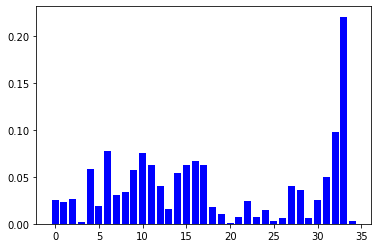

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [39]:
def correlation_selector(x, y):
    correl_dict = {
        col: np.corrcoef(x[col], y)[0, 1] for col in x.columns.tolist()
    }
    correl_dict = {
        col: 0 if np.isnan(cor) else np.abs(cor) for col, cor in correl_dict.items()
    }
    plot_scores(list(correl_dict.values()), 'correlation')
    
    correl_dict = dict(sorted(correl_dict.items(), key=lambda item: item[1], reverse=True)[:top_n_feats])
    top_n = np.array([
        True if col in list(correl_dict.keys()) else False for col in x.columns.tolist()
    ])
    return top_n


corr_top_n = correlation_selector(X, Y)
corr_top_n

#### 3.2 Chi-Squared

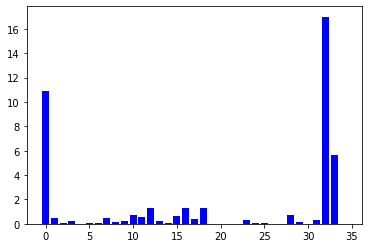

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [40]:
def chi_selector(y):
    chi_sq = SelectKBest(chi2, k=top_n_feats)
    chi_sq.fit(X_norm, y)
    top_n = chi_sq.get_support()
    plot_scores(chi_sq.scores_, 'chi-squared')
    return top_n


chi_top_n = chi_selector(Y)
chi_top_n

#### 3.3 Recursive Feature Elimination

In [41]:
def rfe_selector(y):
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=top_n_feats, step=10, verbose=0)
    rfe.fit(X_norm, y)
    top_n = rfe.get_support()
    return top_n


rfe_top_n = rfe_selector(Y)
rfe_top_n

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

#### 3.4 Lasso: SelectFromModel

In [42]:
def lasso_selector(y):
    lasso = SelectFromModel(LogisticRegression(penalty="l2"), max_features=top_n_feats)
    lasso.fit(X_norm, y)
    top_n = lasso.get_support()
    return top_n


lasso_top_n = lasso_selector(Y)
lasso_top_n

array([False, False, False, False, False,  True, False,  True, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True, False])

#### 3.5 RandomForestClassifier: SelectFromModel

In [43]:
def rfc_selector(x, y):
    rfc = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=top_n_feats)
    rfc.fit(x, y)
    top_n = rfc.get_support()
    return top_n


rfc_top_n = rfc_selector(X, Y)
rfc_top_n

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False])

#### 3.6 Cumulative Feature Selection

In [44]:
cumm_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'correlation': corr_top_n,
    'chi-sq': chi_top_n,
    'rfe': rfe_top_n,
    'lasso': lasso_top_n,
    'rfc': rfc_top_n
})
cumm_df['total'] = np.sum(cumm_df, axis=1)
cumm_df = cumm_df.sort_values(['total', 'feature'], ascending=False)
cumm_df.index = range(1, len(cumm_df) + 1)
cumm_df

,feature,correlation,chi-sq,rfe,lasso,rfc,total
1,resp_rate,True,True,True,True,True,5
2,Ethnicity_Encoded,True,True,True,True,True,5
3,sbp,True,True,True,False,True,4
4,pulse_ox,True,True,True,False,True,4
5,heart_rate,True,True,True,False,True,4
6,dbp,True,True,True,False,True,4
7,cmp_total_protein,True,True,True,True,False,4
8,cmp_sodium,True,True,True,True,False,4
9,cmp_bilirubin,True,True,True,True,False,4
10,cbc_wbc,True,True,True,False,True,4


In [45]:
top_n_features = list(cumm_df.iloc[:top_n_feats]['feature'])
top_n_features

['resp_rate',
 'Ethnicity_Encoded',
 'sbp',
 'pulse_ox',
 'heart_rate',
 'dbp',
 'cmp_total_protein',
 'cmp_sodium',
 'cmp_bilirubin',
 'cbc_wbc',
 'cbc_platelets',
 'cbc_neutrophil_c',
 'cbc_monocyte_c',
 'cbc_lymphocyte_perc',
 'cbc_lymphocyte_c',
 'cbc_hematocrit',
 'cbc_eosinophil_perc.2',
 'cbc_eosinophil_perc',
 'Age',
 'Admitted',
 'cmp_potassium',
 'cmp_glucose',
 'cmp_creatinine',
 'cmp_chloride',
 'cmp_bun',
 'cmp_bicarbonate',
 'cmp_ast',
 'cmp_alt',
 'cmp_alkaline_phosphatase',
 'cmp_albumin',
 'cbc_hemoglobin',
 'cbc_eosinophil_perc.1',
 'cbc_eosinophil_c',
 'Sex_Encoded',
 'FirstRace_Encoded']

## 4. Model Selection

#### 4.1 Train / Test Data

In [46]:
X_train = final_train[top_n_features]
y_train = final_train[target]
X_test = final_test[top_n_features]
y_test = final_test[target]

In [47]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print()
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5904, 35)
y_train (5904,)

X_test (1476, 35)
y_test (1476,)


#### 4.2 Model Construction

###### 4.2.1 Documentation

[Keras Layers/Activation Documentation](https://keras.io/api/layers/)

Loss Functions
* 'binary_crossentropy'
* 'sparse_categorical_crossentropy'

Optimizers
* 'adam'
* 'sgd'

In [48]:
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(SEED)
np.random.seed(SEED)

###### 4.2.2 Models

In [49]:
seq1 = Sequential([
    BatchNormalization(),
    Dense(300, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dense(100, use_bias=False),
    Activation('relu'),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [50]:
seq2 = Sequential([
    Dense(top_n_feats, activation='relu'),
    Dense(6, activation='relu'),
    Dense(2, activation='softmax')
])

In [51]:
seq3 = Sequential([
    Dense(top_n_feats, kernel_initializer='he_normal'),
    PReLU(),
    Dense(6, kernel_initializer='he_normal'),
    PReLU(),
    Dense(2, activation='softmax')
])

In [52]:
# keras.utils.plot_model(model, "seq_model1.png", show_shapes=True)

#### 4.3 Model Evaluation Functions

In [53]:
def plot_metric(hist, metric):
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and Validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [54]:
def plot_history(hist):
    display(Markdown('**Training/Validation Loss and Accuracy**'))
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [55]:
def metric_evaluation(y_test, y_pred):
    display(Markdown('**Metric Scores**'))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

In [56]:
def plot_confusion_matrix(y_test, y_pred):
    display(Markdown('**Confusion Matrix**'))
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, y_pred), columns=['Detected', 'None Detected'], index=['Detected', 'None Detected']
    )
    ax = sns.heatmap(
        data=cm_df, cmap=cm.Blues, annot=True, fmt='d'
    )
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

#### 4.4 Simultaneous Model Evaluation

In [57]:
model_lst = [
    {'name': 'Sequential: Dense + Batch Normalization Layers, ReLU Activations',
     'model': seq1, 'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-4)},
    {'name': 'Sequential: Dense Layers, ReLU Activation',
     'model': seq2, 'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-4)},
    {'name': 'Sequential: Dense Layers, PReLU Activation',
     'model': seq3, 'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-4)}
]

In [58]:
EPOCHS = 30
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [59]:
def test_models(models, xy, isolate=None):
    X_train, y_train, X_test, y_test = xy
    for i, m in enumerate(models):
        name, model, loss, optimizer = m.values()
        if isolate is not None and i + 1 != isolate:
            print('Skipping Model {}...'.format(i + 1))
            continue
        
        display(Markdown('### Model {} – {}'.format(i + 1, name)))
        
        # 1. Compile
        model.compile(
            loss=loss, optimizer=optimizer, metrics=['accuracy']
        )
        
        # 2. Fit
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
        )
        
        # 3. Visualize Model
        display(Markdown("**Summary**"))
        model.summary()
        plot_history(history)
        
        # 4. Evaluate
        display(Markdown("**Evaluation and Prediction**"))
        loss, accuracy = model.evaluate(x=X_test, y=y_test)
        print("\nLoss: {:.2f}%".format(loss * 100))
        print("Accuracy: {:.2f}%".format(accuracy * 100))
        
        # 5. Predict
        y_prediction_array = model.predict(X_test)
        y_prediction = np.argmax(y_prediction_array, axis=1)
        
        # 6. Visualize Predictions
        metric_evaluation(y_test, y_prediction)
        plot_confusion_matrix(y_test, y_prediction)
        
        print()

### Model 1 – Sequential: Dense + Batch Normalization Layers, ReLU Activations

**Summary**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 35)                140       
_________________________________________________________________
dense (Dense)                (None, 300)               10500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30000     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

**Training/Validation Loss and Accuracy**

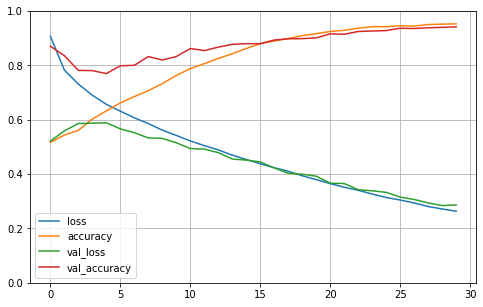

**Evaluation and Prediction**

47/47 [==============================] - 0s 1ms/step - loss: 0.3132 - accuracy: 0.9167

Loss: 31.32%
Accuracy: 91.67%


**Metric Scores**

Accuracy: 91.67%
Precision: 94.75%
Recall: 96.34%
F1: 95.54%

Confusion Matrix:
[[  36   73]
 [  50 1317]]


**Confusion Matrix**

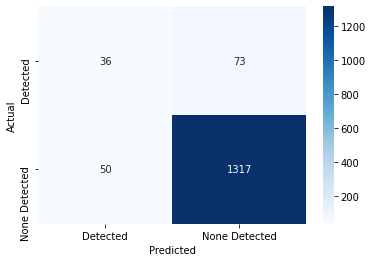

### Model 2 – Sequential: Dense Layers, ReLU Activation

**Summary**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 35)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 216       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
Total params: 1,490
Trainable params: 1,490
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

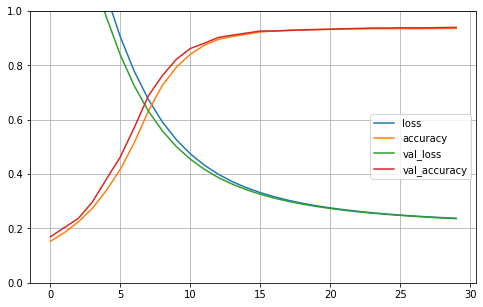

**Evaluation and Prediction**

47/47 [==============================] - 0s 979us/step - loss: 0.2673 - accuracy: 0.9228

Loss: 26.73%
Accuracy: 92.28%


**Metric Scores**

Accuracy: 92.28%
Precision: 92.59%
Recall: 99.63%
F1: 95.98%

Confusion Matrix:
[[   0  109]
 [   5 1362]]


**Confusion Matrix**

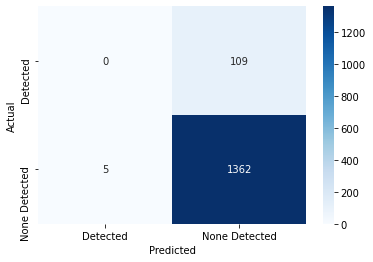

### Model 3 – Sequential: Dense Layers, PReLU Activation

**Summary**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 35)                1260      
_________________________________________________________________
p_re_lu (PReLU)              (None, 35)                35        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 216       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 6)                 6         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 14        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

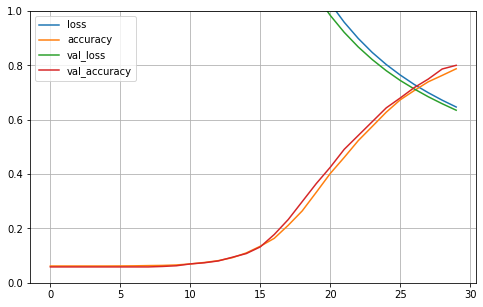

**Evaluation and Prediction**

47/47 [==============================] - 0s 999us/step - loss: 0.6589 - accuracy: 0.7893

Loss: 65.89%
Accuracy: 78.93%


**Metric Scores**

Accuracy: 78.93%
Precision: 92.86%
Recall: 83.69%
F1: 88.03%

Confusion Matrix:
[[  21   88]
 [ 223 1144]]


**Confusion Matrix**

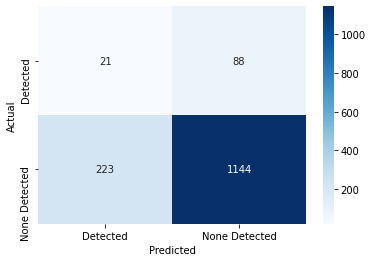

In [60]:
test_models(model_lst, (X_train, y_train, X_test, y_test))

#### Randomized Search

In [109]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[top_n_feats]):
    model = Sequential([
        InputLayer(input_shape=input_shape)
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    optimizer = SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [110]:
keras_reg = KerasRegressor(build_model)

In [119]:
hyperparameters = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

In [120]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

In [121]:
rnd_search_cv = RandomizedSearchCV(keras_reg, hyperparameters, n_iter=10, cv=cv)

In [122]:
rnd_search_cv.fit(
    X_train, y_train, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/30
133/133 [==============================] - 0s 3ms/step - loss: 1.6438 - val_loss: 0.6919
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.5883 - val_loss: 0.3790
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.3475 - val_loss: 0.2640
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2493 - val_loss: 0.2070
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1976 - val_loss: 0.1724
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1662 - val_loss: 0.1508
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1456 - val_loss: 0.1344
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1308 - val_loss: 0.1216
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1196 - val_loss: 0.1119
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1108 - val_loss: 0.1041

Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0748 - val_loss: 0.0738
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0736 - val_loss: 0.0723
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0725 - val_loss: 0.0712
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 0.0700
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0691
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0683
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0672
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0664
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0657
Epoch 30/30
19/19 [==============================] - 0s 804us/step - loss: 0.0705
Epoch 1/3

133/133 [==============================] - 0s 1ms/step - loss: 0.0957 - val_loss: 0.0984
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0897 - val_loss: 0.0923
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0850 - val_loss: 0.0876
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0814 - val_loss: 0.0835
Epoch 14/30
133/133 [==============================] - 0s 3ms/step - loss: 0.0783 - val_loss: 0.0805
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0775
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0753
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0733
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0717
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0703
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0613
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0616
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0607
Epoch 30/30
19/19 [==============================] - 0s 784us/step - loss: 0.0553
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 1.2004 - val_loss: 0.6352
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.4897 - val_loss: 0.3954
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.3253 - val_loss: 0.2857
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2473 - val_loss: 0.2243
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2027 - val_loss: 0.1868
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1736 - val_loss: 0.1627
Epoch 7/30
133/133 [=======

133/133 [==============================] - 0s 1ms/step - loss: 0.0758 - val_loss: 0.0744
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0737 - val_loss: 0.0721
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0703
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0705 - val_loss: 0.0689
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0675
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0664
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0654
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0647
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0635
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0627
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1822 - val_loss: 0.1669
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1478 - val_loss: 0.1426
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1263 - val_loss: 0.1269
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1122 - val_loss: 0.1170
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1026 - val_loss: 0.1075
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0955 - val_loss: 0.1015
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0900 - val_loss: 0.0956
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0858 - val_loss: 0.0910
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0825 - val_loss: 0.0879
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0797 - val_loss: 0.0855
Epoch 

133/133 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0628
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0622
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0618
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0615
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0612
Epoch 30/30
19/19 [==============================] - 0s 773us/step - loss: 0.0584
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 1.2163 - val_loss: 0.5314
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.4544 - val_loss: 0.3128
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2836 - val_loss: 0.2103
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1995 - val_loss: 0.1561
Epoch 5/30
133/133 [=====

133/133 [==============================] - 0s 1ms/step - loss: 0.0838 - val_loss: 0.0881
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0806 - val_loss: 0.0855
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 0.0831
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0756 - val_loss: 0.0807
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0736 - val_loss: 0.0785
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0767
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0754
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0737
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0722
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0714
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.3906 - val_loss: 0.3036
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2648 - val_loss: 0.2267
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2025 - val_loss: 0.1850
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1668 - val_loss: 0.1593
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1445 - val_loss: 0.1425
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1291 - val_loss: 0.1300
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1180 - val_loss: 0.1205
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1098 - val_loss: 0.1139
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1031 - val_loss: 0.1076
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0978 - val_loss: 0.1023
Epoch 13

133/133 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0599
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0592
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0587
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0581
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0577
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0572
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0568
Epoch 30/30
19/19 [==============================] - 0s 756us/step - loss: 0.0598
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 1.6337 - val_loss: 0.8970
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.7146 - val_loss: 0.5164
Epoch 3/30
133/133 [===

133/133 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0717
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0705 - val_loss: 0.0696
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0681
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0665
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0654
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0646
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0636
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0628
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0622
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0615
Ep

133/133 [==============================] - 0s 2ms/step - loss: 1.3141 - val_loss: 0.9269
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.5917 - val_loss: 0.5142
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.3478 - val_loss: 0.3206
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2322 - val_loss: 0.2253
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1727 - val_loss: 0.1731
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1390 - val_loss: 0.1416
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1183 - val_loss: 0.1209
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1045 - val_loss: 0.1069
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0948 - val_loss: 0.0975
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0878 - val_loss: 0.0897
Epoch 11/3

133/133 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0647
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0640
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0634
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0629
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0624
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0620
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0616
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0613
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0610
Epoch 30/30
19/19 [==============================] - 0s 2ms/step - loss: 0.0616
Epoch 1/30
133/133 [===

133/133 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0559
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0553
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0549
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0546
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0544
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0542
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0541
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0540
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0538
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0538
Ep

19/19 [==============================] - 0s 847us/step - loss: 0.0673
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.5156 - val_loss: 0.3079
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2238 - val_loss: 0.1729
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1668 - val_loss: 0.1512
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1507 - val_loss: 0.1382
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1390 - val_loss: 0.1280
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1294 - val_loss: 0.1195
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1215 - val_loss: 0.1125
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1148 - val_loss: 0.1066
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1091 - val_loss: 0.1015
Epoch 10/30
133/133 [=========

133/133 [==============================] - 0s 1ms/step - loss: 0.0902 - val_loss: 0.0912
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0885 - val_loss: 0.0894
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0868 - val_loss: 0.0877
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0853 - val_loss: 0.0861
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0839 - val_loss: 0.0847
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0834
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0821
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0810
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0799
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0789
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1255 - val_loss: 0.1149
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1177 - val_loss: 0.1087
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1115 - val_loss: 0.1037
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1064 - val_loss: 0.0993
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1022 - val_loss: 0.0958
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0985 - val_loss: 0.0928
Epoch 14/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0953 - val_loss: 0.0901
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0926 - val_loss: 0.0878
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0900 - val_loss: 0.0857
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0880 - val_loss: 0.0839
Epo

Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 0.0676
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0670
Epoch 30/30
19/19 [==============================] - 0s 844us/step - loss: 0.0676
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.7614 - val_loss: 0.5129
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.3727 - val_loss: 0.2673
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2024 - val_loss: 0.1571
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1363 - val_loss: 0.1216
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1170 - val_loss: 0.1110
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1096 - val_loss: 0.1052
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1046 - val_loss: 0.1008
Epoch 8/30
133/1

133/133 [==============================] - 0s 1ms/step - loss: 0.0733 - val_loss: 0.0705
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0696
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 0.0689
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0705 - val_loss: 0.0682
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.0675
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0670
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0664
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0659
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0654
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0650
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1575 - val_loss: 0.1400
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1432 - val_loss: 0.1280
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1316 - val_loss: 0.1184
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1223 - val_loss: 0.1111
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1150 - val_loss: 0.1056
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1093 - val_loss: 0.1009
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1045 - val_loss: 0.0969
Epoch 13/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.0935
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0968 - val_loss: 0.0904
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0937 - val_loss: 0.0877
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0661
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0656
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0651
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0647
Epoch 30/30
19/19 [==============================] - 0s 913us/step - loss: 0.0655
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2952 - val_loss: 0.1891
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1972 - val_loss: 0.1718
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1780 - val_loss: 0.1588
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1634 - val_loss: 0.1475
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1513 - val_loss: 0.1386
Epoch 6/30
133/133 [======

133/133 [==============================] - 0s 2ms/step - loss: 0.0920 - val_loss: 0.0869
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.0830
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0847 - val_loss: 0.0795
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0818 - val_loss: 0.0765
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0793 - val_loss: 0.0738
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0771 - val_loss: 0.0715
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0695
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.0677
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0661
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 0.0648
Ep

Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2568 - val_loss: 0.2017
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2119 - val_loss: 0.1784
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1895 - val_loss: 0.1613
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1718 - val_loss: 0.1476
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1573 - val_loss: 0.1360
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1454 - val_loss: 0.1264
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1354 - val_loss: 0.1184
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1269 - val_loss: 0.1116
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1196 - val_loss: 0.1058
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1133 - val_loss: 0.100

Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0645
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0640
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0637
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0648
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0635
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0629
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0578 - val_loss: 0.0627
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.0624
Epoch 30/30
19/19 [==============================] - 0s 832us/step - loss: 0.0640
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2187 - val_loss: 0.1232
Epoch 2/30

133/133 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0684
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0678
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0668
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0657
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0653
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0649
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0641
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0639
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0627
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0623
Ep

19/19 [==============================] - 0s 933us/step - loss: 0.0609
Epoch 1/30
133/133 [==============================] - 0s 4ms/step - loss: 0.2940 - val_loss: 0.1251
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1165 - val_loss: 0.0957
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.0854
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0863 - val_loss: 0.0796
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0808 - val_loss: 0.0750
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0770 - val_loss: 0.0725
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0742 - val_loss: 0.0702
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0689
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0681
Epoch 10/30
133/133 [=========

133/133 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0587
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0592 - val_loss: 0.0586
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0581
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0580
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0576
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0575
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0578 - val_loss: 0.0574
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0569
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.0569
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.0565
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0696
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0684
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0675
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0681
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0661
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0653
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0656
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0646
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0641
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0646
Ep

Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0574
Epoch 30/30
19/19 [==============================] - 0s 927us/step - loss: 0.0658
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2920 - val_loss: 0.1811
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1305 - val_loss: 0.1072
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1030 - val_loss: 0.0959
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0927 - val_loss: 0.0908
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0859 - val_loss: 0.0836
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0809 - val_loss: 0.0795
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0771 - val_loss: 0.0773
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0743
Epoch 9/30
133/13

133/133 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0585
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0578
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0581
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0572
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0574
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0569
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0564
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0567
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0566
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0558
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.0835
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0750 - val_loss: 0.0808
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0783
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0767
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0749
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0732
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0723
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0713
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0699
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0697
Epoc

Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0611
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0604
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0603
Epoch 30/30
19/19 [==============================] - 0s 882us/step - loss: 0.0613
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2625 - val_loss: 0.1286
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1156 - val_loss: 0.0974
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0944 - val_loss: 0.0857
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0847 - val_loss: 0.0797
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0793 - val_loss: 0.0760
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0745
Epoch 7/30
133/

133/133 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0694
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0691
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0686
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0684
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0677
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0677
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0668
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0660
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0659
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0654
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0816
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0797
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0748 - val_loss: 0.0760
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0741
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0730
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0705
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0696
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0689
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0673
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0679
Epoch 

133/133 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0600
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0565 - val_loss: 0.0596
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0608
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0593
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0557 - val_loss: 0.0595
Epoch 30/30
19/19 [==============================] - 0s 904us/step - loss: 0.0616
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.7086 - val_loss: 0.3528
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2940 - val_loss: 0.2346
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2103 - val_loss: 0.1845
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1710 - val_loss: 0.1557
Epoch 5/30
133/133 [=====

133/133 [==============================] - 0s 1ms/step - loss: 0.0850 - val_loss: 0.0778
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0756
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0809 - val_loss: 0.0743
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0792 - val_loss: 0.0729
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0776 - val_loss: 0.0713
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0764 - val_loss: 0.0702
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0690
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0740 - val_loss: 0.0681
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0730 - val_loss: 0.0672
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0667
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1556 - val_loss: 0.1398
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1309 - val_loss: 0.1224
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1153 - val_loss: 0.1106
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1048 - val_loss: 0.1022
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0972 - val_loss: 0.0960
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0915 - val_loss: 0.0912
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0870 - val_loss: 0.0873
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0835 - val_loss: 0.0842
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0806 - val_loss: 0.0816
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0794
Epoch 13

133/133 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0759
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0717 - val_loss: 0.0747
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0709 - val_loss: 0.0739
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0732
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0722
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0715
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0708
Epoch 30/30
19/19 [==============================] - 0s 816us/step - loss: 0.0669
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.5322 - val_loss: 0.2880
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2417 - val_loss: 0.1923
Epoch 3/30
133/133 [===

133/133 [==============================] - 0s 1ms/step - loss: 0.0869 - val_loss: 0.0811
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0847 - val_loss: 0.0791
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0828 - val_loss: 0.0775
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0811 - val_loss: 0.0759
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0796 - val_loss: 0.0749
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0783 - val_loss: 0.0737
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0771 - val_loss: 0.0723
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0759 - val_loss: 0.0714
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0750 - val_loss: 0.0704
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0695
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.7629 - val_loss: 0.3565
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.3062 - val_loss: 0.2472
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2299 - val_loss: 0.1990
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1917 - val_loss: 0.1725
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1674 - val_loss: 0.1545
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1503 - val_loss: 0.1426
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1377 - val_loss: 0.1307
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1277 - val_loss: 0.1248
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1199 - val_loss: 0.1161
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1134 - val_loss: 0.1110
Epoch 11/3

133/133 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 0.0676
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0667
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0663
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0653
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0647
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0641
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0636
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0629
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0625
Epoch 30/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0612
Epoch 1/30
133/133 [===

133/133 [==============================] - 0s 1ms/step - loss: 0.0939 - val_loss: 0.0930
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0902 - val_loss: 0.0901
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0872 - val_loss: 0.0875
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0846 - val_loss: 0.0852
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0822 - val_loss: 0.0833
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0801 - val_loss: 0.0817
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0784 - val_loss: 0.0802
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0768 - val_loss: 0.0788
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0753 - val_loss: 0.0774
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0741 - val_loss: 0.0764
Ep

19/19 [==============================] - 0s 852us/step - loss: 0.0666
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.6561 - val_loss: 0.3773
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2658 - val_loss: 0.2534
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.2038
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1664 - val_loss: 0.1768
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1491 - val_loss: 0.1587
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1370 - val_loss: 0.1456
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1278 - val_loss: 0.1357
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1204 - val_loss: 0.1275
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1142 - val_loss: 0.1211
Epoch 10/30
133/133 [=========

133/133 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0818
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0769 - val_loss: 0.0802
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0754 - val_loss: 0.0797
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0744 - val_loss: 0.0779
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.0769
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0725 - val_loss: 0.0757
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0745
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 0.0737
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0731
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0731
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1046 - val_loss: 0.1021
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0998 - val_loss: 0.0980
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0957 - val_loss: 0.0939
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0923 - val_loss: 0.0906
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0892 - val_loss: 0.0883
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0865 - val_loss: 0.0859
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0843 - val_loss: 0.0832
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0823 - val_loss: 0.0813
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0805 - val_loss: 0.0795
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0781
Epo

133/133 [==============================] - 0s 1ms/step - loss: 0.0736 - val_loss: 0.0699
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 0.0691
Epoch 30/30
19/19 [==============================] - 0s 917us/step - loss: 0.0787
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.5403 - val_loss: 0.3155
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2725 - val_loss: 0.2245
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2090 - val_loss: 0.1818
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.1554
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1500 - val_loss: 0.1375
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1333 - val_loss: 0.1245
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1214 - val_loss: 0.1149
Epoch 8/30
133/133 [========

133/133 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.0720
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0711
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0710
Epoch 20/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0703
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0692
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0697
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0684
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0675
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0671
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0668
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0831 - val_loss: 0.0747
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0712
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0691
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0666
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0650
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0637
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0631
Epoch 13/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0617
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0609
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0602
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0654
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0650
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0647
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0643
Epoch 30/30
19/19 [==============================] - 0s 956us/step - loss: 0.0689
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2168 - val_loss: 0.1577
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1500 - val_loss: 0.1292
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1257 - val_loss: 0.1118
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1100 - val_loss: 0.1004
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0996 - val_loss: 0.0926
Epoch 6/30
133/133 [======

133/133 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0687
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0680
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0674
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0669
Epoch 19/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0664
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0658
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0654
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0651
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0647
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0643
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.1022 - val_loss: 0.0958
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0943 - val_loss: 0.0916
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0890 - val_loss: 0.0865
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0830
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0807
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0784
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0764
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0743
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0732
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0728
Epoch 1

133/133 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0607
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0604
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0604
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0599
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0597
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0595
Epoch 30/30
19/19 [==============================] - 0s 936us/step - loss: 0.0656
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2368 - val_loss: 0.1542
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1627 - val_loss: 0.1227
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1318 - val_loss: 0.1056
Epoch 4/30
133/133 [====

133/133 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0688
Epoch 14/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0680
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0672
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0665
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0659
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0653
Epoch 19/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0648
Epoch 20/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0644
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0642
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0636
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.1339 - val_loss: 0.1183
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1144 - val_loss: 0.1052
Epoch 4/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1035 - val_loss: 0.0971
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0962 - val_loss: 0.0926
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0907 - val_loss: 0.0882
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0866 - val_loss: 0.0855
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0831 - val_loss: 0.0821
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0803 - val_loss: 0.0800
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0784
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.0762
Epoch 12/

133/133 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0645
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0641
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0637
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0634
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0631
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0628
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0626
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0623
Epoch 30/30
19/19 [==============================] - 0s 948us/step - loss: 0.0676
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2287 - val_loss: 0.1457
Epoch 2/30
133/133 [==

133/133 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0690
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0678
Epoch 13/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0667
Epoch 14/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0658
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0649
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0641
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0635
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0630
Epoch 19/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0625
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0620
Ep

19/19 [==============================] - 0s 895us/step - loss: 0.0629
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2174 - val_loss: 0.1651
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1417 - val_loss: 0.1302
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1167 - val_loss: 0.1121
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1030 - val_loss: 0.1006
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0943 - val_loss: 0.0933
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0885 - val_loss: 0.0882
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0844 - val_loss: 0.0844
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.0809
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0785
Epoch 10/30
133/133 [=========

133/133 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0546
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0508 - val_loss: 0.0542
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0505 - val_loss: 0.0542
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0541
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0553
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0500 - val_loss: 0.0542
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0497 - val_loss: 0.0553
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0543
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0538
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0491 - val_loss: 0.0537
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0569
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0563
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 0.0558
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0564
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0532 - val_loss: 0.0556
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0552
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0525 - val_loss: 0.0558
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0563
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0545
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0518 - val_loss: 0.0547
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0540
Epoch 30/30
19/19 [==============================] - 0s 888us/step - loss: 0.0558
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1356 - val_loss: 0.0746
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0759 - val_loss: 0.0665
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0858 - val_loss: 0.0635
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0837 - val_loss: 0.0608
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0720
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0563
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0557
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0554
Epoch 9/30
133/133 [=========

133/133 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0583
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0509 - val_loss: 0.0532
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0504 - val_loss: 0.0523
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0522
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0523
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0498 - val_loss: 0.0521
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0527
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0490 - val_loss: 0.0523
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.0532
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0593
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0587
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0538 - val_loss: 0.0572
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0599
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0566
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0523 - val_loss: 0.0568
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0566
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0517 - val_loss: 0.0562
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0514 - val_loss: 0.0576
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0511 - val_loss: 0.0553
Epoc

133/133 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0517
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0520
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0492 - val_loss: 0.0515
Epoch 30/30
19/19 [==============================] - 0s 874us/step - loss: 0.0585
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1806 - val_loss: 0.1901
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2085 - val_loss: 0.0822
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1144 - val_loss: 0.0613
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0571
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0558
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0563 - val_loss: 0.0550
Epoch 7/30
133/133 [=======

133/133 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0538
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0542
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0535
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0516 - val_loss: 0.0532
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0515 - val_loss: 0.0546
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0513 - val_loss: 0.0530
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0511 - val_loss: 0.0529
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0508 - val_loss: 0.0530
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0508 - val_loss: 0.0527
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0505 - val_loss: 0.0529
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0585
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0567 - val_loss: 0.0572
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0559
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0548 - val_loss: 0.0564
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.0552
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0550
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0529 - val_loss: 0.0544
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0525 - val_loss: 0.0549
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0549
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0518 - val_loss: 0.0542
Epoch 

133/133 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0557
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0555
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0556
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0494 - val_loss: 0.0552
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0492 - val_loss: 0.0558
Epoch 30/30
19/19 [==============================] - 0s 847us/step - loss: 0.0567
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1895 - val_loss: 0.1159
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1416 - val_loss: 0.0823
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0908 - val_loss: 0.0655
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0604
Epoch 5/30
133/133 [=====

133/133 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0560
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0530 - val_loss: 0.0557
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0527 - val_loss: 0.0557
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0526 - val_loss: 0.0554
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0575
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0562
Epoch 20/30
133/133 [==============================] - ETA: 0s - loss: 0.052 - 0s 1ms/step - loss: 0.0518 - val_loss: 0.0561
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0517 - val_loss: 0.0557
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0550
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.05

133/133 [==============================] - 0s 1ms/step - loss: 0.0872 - val_loss: 0.0706
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0726 - val_loss: 0.2261
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0610
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0606
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0610
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0587
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0566 - val_loss: 0.0560
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0625
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0556 - val_loss: 0.0552
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0545 - val_loss: 0.0549
Epoch 12/

133/133 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0555
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0566
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0576
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0488 - val_loss: 0.0560
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0490 - val_loss: 0.0552
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.0579
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0487 - val_loss: 0.0554
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0552
Epoch 30/30
19/19 [==============================] - 0s 826us/step - loss: 0.0604
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.3503 - val_loss: 0.0884
Epoch 2/30
133/133 [==

133/133 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0568
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.0567
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.0554
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0550 - val_loss: 0.0572
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0546 - val_loss: 0.0550
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0552
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0546
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0537 - val_loss: 0.0550
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 0.0546
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0537 - val_loss: 0.0541
Ep

19/19 [==============================] - 0s 866us/step - loss: 0.0575
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2269 - val_loss: 0.1391
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0967 - val_loss: 0.0950
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0806 - val_loss: 0.0761
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0798
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0675
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0641
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0629
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0619
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0592
Epoch 10/30
133/133 [=========

133/133 [==============================] - 0s 1ms/step - loss: 0.0534 - val_loss: 0.0534
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0533 - val_loss: 0.0542
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0532 - val_loss: 0.0562
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0531 - val_loss: 0.0533
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0545
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0527 - val_loss: 0.0534
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0527 - val_loss: 0.0533
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0526 - val_loss: 0.0532
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0535
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0524 - val_loss: 0.0523
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0512
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.0513
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0565 - val_loss: 0.0507
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0559 - val_loss: 0.0508
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0507
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0504
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.0507
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0519
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0548 - val_loss: 0.0499
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0547 - val_loss: 0.0494
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0538 - val_loss: 0.0511
Epoch 30/30
19/19 [==============================] - 0s 823us/step - loss: 0.0538
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2607 - val_loss: 0.1119
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0994 - val_loss: 0.0901
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0890 - val_loss: 0.0748
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0696
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0657
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0621
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0631
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0672
Epoch 9/30
133/133 [=========

133/133 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.0538
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.0532
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0546 - val_loss: 0.0539
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0544 - val_loss: 0.0530
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0540
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0528
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0524
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0529
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 0.0523
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 0.0556
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0605
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.0597
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0583
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0556 - val_loss: 0.0599
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0550 - val_loss: 0.0595
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0544 - val_loss: 0.0586
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0544 - val_loss: 0.0567
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 0.0569
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0537 - val_loss: 0.0567
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0534 - val_loss: 0.0579
Epoc

133/133 [==============================] - 0s 1ms/step - loss: 0.0524 - val_loss: 0.0550
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0524 - val_loss: 0.0538
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0557
Epoch 30/30
19/19 [==============================] - 0s 867us/step - loss: 0.0521
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2702 - val_loss: 0.1127
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0952 - val_loss: 0.0839
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0757
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0696
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0663
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0643
Epoch 7/30
133/133 [=======

133/133 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0544
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0547 - val_loss: 0.0530
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0537
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0550
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.0527
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0538 - val_loss: 0.0526
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0537 - val_loss: 0.0535
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0536 - val_loss: 0.0522
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0534 - val_loss: 0.0523
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0519
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0667
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0604
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0596
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0571 - val_loss: 0.0572
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0565 - val_loss: 0.0573
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0560
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0558
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0544 - val_loss: 0.0551
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0542 - val_loss: 0.0549
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 0.0552
Epoch 

133/133 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0515
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0526 - val_loss: 0.0507
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0525 - val_loss: 0.0509
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0523 - val_loss: 0.0511
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0510
Epoch 30/30
19/19 [==============================] - 0s 848us/step - loss: 0.0558
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1762 - val_loss: 0.0869
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0844 - val_loss: 0.0719
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0733 - val_loss: 0.0681
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0638
Epoch 5/30
133/133 [=====

133/133 [==============================] - 0s 1ms/step - loss: 0.0922 - val_loss: 0.1003
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0897 - val_loss: 0.0979
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0877 - val_loss: 0.0957
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0858 - val_loss: 0.0938
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0842 - val_loss: 0.0921
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0826 - val_loss: 0.0906
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0812 - val_loss: 0.0892
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0799 - val_loss: 0.0879
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0868
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0777 - val_loss: 0.0857
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.1577
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1524 - val_loss: 0.1409
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1373 - val_loss: 0.1294
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1267 - val_loss: 0.1208
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1189 - val_loss: 0.1141
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1130 - val_loss: 0.1090
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1081 - val_loss: 0.1047
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1042 - val_loss: 0.1011
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1009 - val_loss: 0.0985
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0982 - val_loss: 0.0956
Epoch 13

133/133 [==============================] - 0s 1ms/step - loss: 0.0796 - val_loss: 0.0788
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0786 - val_loss: 0.0779
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0776 - val_loss: 0.0771
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0768 - val_loss: 0.0762
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0759 - val_loss: 0.0757
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0748
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0744 - val_loss: 0.0742
Epoch 30/30
19/19 [==============================] - 0s 883us/step - loss: 0.0781
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.4225 - val_loss: 0.2702
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2345 - val_loss: 0.2128
Epoch 3/30
133/133 [===

133/133 [==============================] - 0s 1ms/step - loss: 0.1014 - val_loss: 0.1026
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0983 - val_loss: 0.0995
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0955 - val_loss: 0.0968
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0932 - val_loss: 0.0943
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0910 - val_loss: 0.0919
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0890 - val_loss: 0.0899
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0872 - val_loss: 0.0881
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0855 - val_loss: 0.0864
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0841 - val_loss: 0.0848
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0827 - val_loss: 0.0834
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.5381 - val_loss: 0.2252
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2086 - val_loss: 0.1668
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1624 - val_loss: 0.1375
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1376 - val_loss: 0.1205
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1228 - val_loss: 0.1098
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1128 - val_loss: 0.1022
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1059 - val_loss: 0.0966
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1007 - val_loss: 0.0922
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0966 - val_loss: 0.0890
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0933 - val_loss: 0.0860
Epoch 11/3

133/133 [==============================] - 0s 1ms/step - loss: 0.0791 - val_loss: 0.0892
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0781 - val_loss: 0.0881
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0772 - val_loss: 0.0873
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0764 - val_loss: 0.0863
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0756 - val_loss: 0.0857
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0748 - val_loss: 0.0850
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0742 - val_loss: 0.0842
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.0837
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0830
Epoch 30/30
19/19 [==============================] - 0s 800us/step - loss: 0.0850
Epoch 1/30
133/133 [=

133/133 [==============================] - 0s 1ms/step - loss: 0.1012 - val_loss: 0.0979
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0977 - val_loss: 0.0950
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0947 - val_loss: 0.0923
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0921 - val_loss: 0.0904
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0900 - val_loss: 0.0887
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0880 - val_loss: 0.0869
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0865 - val_loss: 0.0855
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0849 - val_loss: 0.0843
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0837 - val_loss: 0.0832
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0825 - val_loss: 0.0821
Ep

Epoch 30/30
19/19 [==============================] - 0s 946us/step - loss: 0.0816
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.3777 - val_loss: 0.2907
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2510 - val_loss: 0.2223
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1977 - val_loss: 0.1843
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1672 - val_loss: 0.1606
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1470 - val_loss: 0.1438
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1331 - val_loss: 0.1324
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1230 - val_loss: 0.1235
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1152 - val_loss: 0.1168
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1093 - val_loss: 0.1113
Epoch 10/30
133/13

133/133 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0869
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0767 - val_loss: 0.0861
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0759 - val_loss: 0.0851
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0844
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0745 - val_loss: 0.0836
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0739 - val_loss: 0.0830
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 0.0821
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0727 - val_loss: 0.0815
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0722 - val_loss: 0.0807
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0801
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1092 - val_loss: 0.0929
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1031 - val_loss: 0.0887
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0981 - val_loss: 0.0851
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0940 - val_loss: 0.0821
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0906 - val_loss: 0.0796
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0877 - val_loss: 0.0774
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0852 - val_loss: 0.0755
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0830 - val_loss: 0.0738
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0811 - val_loss: 0.0724
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0794 - val_loss: 0.0711
Epo

133/133 [==============================] - 0s 1ms/step - loss: 0.0738 - val_loss: 0.0753
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 0.0747
Epoch 30/30
19/19 [==============================] - 0s 943us/step - loss: 0.0827
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.3482 - val_loss: 0.2607
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2253 - val_loss: 0.2007
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1748
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1551 - val_loss: 0.1582
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1396 - val_loss: 0.1462
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1283 - val_loss: 0.1370
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1203 - val_loss: 0.1301
Epoch 8/30
133/133 [========

133/133 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0527
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0525
Epoch 19/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0529
Epoch 20/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0520
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0520
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0519
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0516
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0519
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0518
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0521
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0584
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0585
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0583
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0575
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0572
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0565
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0571
Epoch 13/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0564
Epoch 14/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0562
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0560
Epoch

133/133 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0549
Epoch 27/30
133/133 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0551
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0547
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0557
Epoch 30/30
19/19 [==============================] - 0s 2ms/step - loss: 0.0572
Epoch 1/30
133/133 [==============================] - 0s 3ms/step - loss: 0.1326 - val_loss: 0.0808
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0695
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0674
Epoch 4/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0615
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0614
Epoch 6/30
133/133 [========

133/133 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0560
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0537
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0543
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0574
Epoch 19/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0535
Epoch 20/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0532
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0544
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0529
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0541
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0528
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0576
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0567
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0557
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0555
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0562
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0550
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0556
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0540
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0553
Epoch 13/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0539
Epoch 1

133/133 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0525
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0527
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0524
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0523
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0533
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0532
Epoch 30/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1424 - val_loss: 0.1054
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0686
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0786 - val_loss: 0.0597
Epoch 4/30
133/133 [======

133/133 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0527
Epoch 14/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0521
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0535
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0520
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0520
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0516
Epoch 19/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0517
Epoch 20/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0530
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0514
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0515
Ep

133/133 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0655
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0628
Epoch 4/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0622
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0601
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0592
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0596
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0597
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0577
Epoch 10/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0574
Epoch 11/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0572
Epoch 12/

133/133 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0556
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0547
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0539
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0540
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0540
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0544
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0539
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0552
Epoch 30/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1258 - val_loss: 0.0815
Epoch 2/30
133/133 [====

133/133 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0561
Epoch 12/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0557
Epoch 13/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0560
Epoch 14/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0554
Epoch 15/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0554
Epoch 16/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0555
Epoch 17/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0551
Epoch 18/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0598
Epoch 19/30
133/133 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0562
Epoch 20/30
133/133 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0559
Ep

19/19 [==============================] - 0s 1ms/step - loss: 0.0550
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.1432 - val_loss: 0.0774
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0620
Epoch 3/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.1378
Epoch 4/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0574
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0549
Epoch 6/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0545
Epoch 7/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0538
Epoch 8/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0530
Epoch 9/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0536
Epoch 10/30
133/133 [===========

133/133 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0528
Epoch 21/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0517
Epoch 22/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0514
Epoch 23/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0530
Epoch 24/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 25/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0521
Epoch 26/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0513
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0528
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0512
Epoch 29/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0515
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0974 - val_loss: 0.1070
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0935 - val_loss: 0.1029
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0904 - val_loss: 0.0995
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0876 - val_loss: 0.0970
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0852 - val_loss: 0.0940
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0833 - val_loss: 0.0919
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0815 - val_loss: 0.0905
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0800 - val_loss: 0.0879
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0786 - val_loss: 0.0862
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0772 - val_loss: 0.0847
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.0762 - val_loss: 0.0738
Epoch 30/30
19/19 [==============================] - 0s 882us/step - loss: 0.1098
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.5965 - val_loss: 0.3184
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2789 - val_loss: 0.2280
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2112 - val_loss: 0.1903
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1670
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1562 - val_loss: 0.1523
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1419 - val_loss: 0.1385
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1309 - val_loss: 0.1300
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1230 - val_loss: 0.1238
Epoch 9/30
133/133 [=========

133/133 [==============================] - 0s 1ms/step - loss: 0.0790 - val_loss: 0.0735
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0778 - val_loss: 0.0726
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0766 - val_loss: 0.0717
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0755 - val_loss: 0.0709
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0746 - val_loss: 0.0704
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0737 - val_loss: 0.0696
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0690
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0684
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 0.0680
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 0.0673
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1154 - val_loss: 0.1076
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1090 - val_loss: 0.1019
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1041 - val_loss: 0.0969
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0999 - val_loss: 0.0935
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0964 - val_loss: 0.0897
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0934 - val_loss: 0.0866
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0906 - val_loss: 0.0851
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0882 - val_loss: 0.0818
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0862 - val_loss: 0.0803
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0843 - val_loss: 0.0785
Epoc

133/133 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0721
Epoch 28/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0714
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0708
Epoch 30/30
19/19 [==============================] - 0s 819us/step - loss: 0.0730
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.4787 - val_loss: 0.2912
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 0.2706 - val_loss: 0.2089
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2048 - val_loss: 0.1672
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1698 - val_loss: 0.1450
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1478 - val_loss: 0.1310
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1330 - val_loss: 0.1198
Epoch 7/30
133/133 [=======

133/133 [==============================] - 0s 1ms/step - loss: 0.0783 - val_loss: 0.0769
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0767 - val_loss: 0.0754
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0753 - val_loss: 0.0740
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0740 - val_loss: 0.0726
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 0.0715
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.0705
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0709 - val_loss: 0.0696
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0688
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0680
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0672
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss: 0.1692
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1625 - val_loss: 0.1544
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1496 - val_loss: 0.1436
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1391 - val_loss: 0.1348
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1302 - val_loss: 0.1278
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1230 - val_loss: 0.1214
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1171 - val_loss: 0.1166
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1119 - val_loss: 0.1121
Epoch 13/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1073 - val_loss: 0.1082
Epoch 14/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1034 - val_loss: 0.1045
Epoch 

133/133 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0703
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0695
Epoch 27/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0689
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0682
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0682
Epoch 30/30
19/19 [==============================] - 0s 984us/step - loss: 0.0647
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.7762 - val_loss: 0.4467
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.3688 - val_loss: 0.2958
Epoch 3/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2616 - val_loss: 0.2268
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2054 - val_loss: 0.1873
Epoch 5/30
133/133 [=====

133/133 [==============================] - 0s 1ms/step - loss: 0.0827 - val_loss: 0.0809
Epoch 15/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0809 - val_loss: 0.0794
Epoch 16/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0791 - val_loss: 0.0778
Epoch 17/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0776 - val_loss: 0.0763
Epoch 18/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0762 - val_loss: 0.0749
Epoch 19/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0739
Epoch 20/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0739 - val_loss: 0.0726
Epoch 21/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 0.0720
Epoch 22/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.0705
Epoch 23/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 0.0697
Ep

133/133 [==============================] - 0s 1ms/step - loss: 0.2304 - val_loss: 0.2095
Epoch 4/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1878 - val_loss: 0.1795
Epoch 5/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1630 - val_loss: 0.1594
Epoch 6/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1462 - val_loss: 0.1441
Epoch 7/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1337 - val_loss: 0.1329
Epoch 8/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1240 - val_loss: 0.1239
Epoch 9/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1164 - val_loss: 0.1167
Epoch 10/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1100 - val_loss: 0.1112
Epoch 11/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1048 - val_loss: 0.1061
Epoch 12/30
133/133 [==============================] - 0s 1ms/step - loss: 0.1003 - val_loss: 0.1021
Epoch 13

133/133 [==============================] - 0s 1ms/step - loss: 0.0780 - val_loss: 0.0770
Epoch 24/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0770 - val_loss: 0.0758
Epoch 25/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0760 - val_loss: 0.0748
Epoch 26/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0739
Epoch 27/30
133/133 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0732
Epoch 28/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0734 - val_loss: 0.0724
Epoch 29/30
133/133 [==============================] - 0s 1ms/step - loss: 0.0727 - val_loss: 0.0716
Epoch 30/30
19/19 [==============================] - 0s 809us/step - loss: 0.1192
Epoch 1/30
133/133 [==============================] - 0s 2ms/step - loss: 0.7587 - val_loss: 0.3632
Epoch 2/30
133/133 [==============================] - 0s 1ms/step - loss: 0.2823 - val_loss: 0.2284
Epoch 3/30
133/133 [===

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x153c8d278>, as the constructor either does not set or modifies parameter learning_rate

## Random Data Generation

In [61]:
new_data_points = 7500

In [62]:
new_data = pd.DataFrame()

In [63]:
%%time

total = len(trim_df4)
for col in trim_df4.columns.tolist():
    if col in code_cols:
        counts = trim_df4[col].value_counts()
        choices = list(counts.index)
        weights = [count/total for count in counts.values]
        new_data[col] = np.random.choice(
            a=choices, p=weights, size=(new_data_points,)
        )
    else:
        new_data[col] = np.random.normal(
            loc=trim_df4[col].mean(), scale=trim_df4[col].std(), size=new_data_points
        )

CPU times: user 62.6 ms, sys: 5.05 ms, total: 67.7 ms
Wall time: 97.8 ms


In [64]:
new_data.head(5)

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,78.438444,73.277885,156.881486,76.346841,97.711297,18.817744,15.862348,45.024476,11.500963,...,136.648429,129.490561,67.069754,7.851282,4.570266,1.280431,1.0,9.0,2.0,0.0
1,1,52.772321,100.576372,154.224812,79.056662,97.471674,31.451582,12.083587,29.666454,15.946343,...,256.838327,-89.741361,218.627968,7.188622,2.871096,3.502710,1.0,0.0,2.0,0.0
2,1,64.131080,79.989263,110.997963,57.555526,93.152107,33.090349,5.980147,33.124933,10.481041,...,-238.210894,169.635051,171.204837,6.135956,2.600180,2.271566,1.0,9.0,2.0,1.0
3,1,50.906483,88.074400,135.935841,64.949152,102.002380,24.481826,11.416264,41.283126,9.271202,...,99.095210,43.246308,-91.439342,7.727635,3.959345,0.223195,1.0,5.0,2.0,0.0
4,0,7.751812,118.415307,153.297936,84.453330,87.529000,10.295213,16.778923,30.264456,13.196143,...,215.307924,92.267308,98.727583,6.907905,3.153272,-1.888499,1.0,0.0,2.0,1.0


In [65]:
new_data.shape

(7500, 36)

In [66]:
real = trim_df4.describe()
fake = new_data.describe()
fake

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.401467,48.977792,94.827625,135.892879,75.739349,97.112193,21.021449,10.180191,38.709594,12.657374,...,43.346349,53.967180,114.207521,7.209553,3.852652,0.859927,0.935733,6.612133,1.952000,0.496933
std,0.490228,23.559729,23.501569,26.710879,15.456168,3.810889,6.676661,7.426270,6.247412,2.202478,...,144.131031,124.924238,76.709748,0.698645,0.495229,1.468927,0.245244,3.757602,0.353807,0.501356
min,0.000000,-43.299418,4.645046,36.969653,8.107169,83.177313,-7.884580,-14.911363,12.743121,4.147882,...,-456.295836,-423.734074,-166.816802,4.381355,1.663546,-4.490048,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.173811,78.937922,117.194061,65.222349,94.494904,16.599991,5.169603,34.438037,11.165448,...,-54.885383,-29.196799,62.605715,6.740892,3.513387,-0.146897,1.000000,5.000000,2.000000,0.000000
50%,0.000000,48.881006,94.947328,135.973359,75.781082,97.101627,21.075594,10.234808,38.742682,12.662030,...,43.459031,54.534232,115.042789,7.220184,3.846401,0.851475,1.000000,9.000000,2.000000,0.000000
75%,1.000000,64.820759,110.976791,154.096438,86.363614,99.726895,25.484283,15.275722,42.942989,14.129651,...,141.954348,138.085115,165.442869,7.683667,4.183891,1.875452,1.000000,9.000000,2.000000,1.000000
max,1.000000,132.001000,198.928685,233.842087,132.739792,110.588693,43.928290,37.676143,60.304864,21.030687,...,587.019769,507.084156,397.237740,9.660924,5.543099,6.153701,1.000000,9.000000,4.000000,2.000000


In [67]:
mean_real = real.iloc[1]
mean_fake = fake.iloc[1]
std_real = real.iloc[2]
std_fake = fake.iloc[2]

In [68]:
(mean_real - mean_fake).mean()

0.09163648391432695

In [69]:
(std_real - std_fake).mean()

-0.05858454513701034

In [70]:
new_df = pd.concat([trim_df4, new_data], axis=0).reset_index().drop(columns=['index'])

In [71]:
new_df.head(5)

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,78.0,94.0,138.0,82.0,96.0,29.0,14.01,34.1,11.0,...,14.0,26.000000,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,23.0,121.0,134.0,88.0,98.0,18.0,5.04,36.2,11.9,...,73.0,55.627858,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,55.0,83.0,152.0,76.0,98.0,21.0,7.13,36.0,12.0,...,26.0,29.000000,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,50.0,88.0,138.0,65.0,87.0,18.0,5.74,32.9,11.6,...,22.0,55.627858,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,67.0,90.0,128.0,69.0,98.0,18.0,10.56,31.7,9.8,...,12.0,18.000000,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


In [72]:
new_df.shape

(14880, 36)

In [73]:
codes_df2 = new_df[code_cols]
trim_df6 = new_df.drop(columns=code_cols)
scaler2 = StandardScaler()
scaled_df2 = pd.DataFrame(data=scaler2.fit_transform(trim_df6), columns=trim_df6.columns.tolist())
merged_df2 = pd.concat([scaled_df2, codes_df2], axis=1)
merged_df2.head()

,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,cbc_platelets,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,COVIDResult_Encoded
0,1.232826,-0.029050,0.076388,0.398710,-0.285183,1.189659,0.517899,-0.729687,-0.747168,0.620033,...,-0.231434,-0.444896,1.836084,0.910591,-0.239664,1,9.0,2.0,0.0,1.0
1,-1.103498,1.124564,-0.072313,0.789975,0.238753,-0.451303,-0.697223,-0.392674,-0.340862,0.725198,...,0.006728,-0.184581,1.266752,1.516856,-0.171663,0,9.0,2.0,0.0,1.0
2,0.255818,-0.499041,0.596844,0.007445,0.238753,-0.003768,-0.414101,-0.424770,-0.295717,-0.084577,...,-0.207319,-0.106487,-0.156580,0.304327,-0.103662,0,0.0,2.0,1.0,1.0
3,0.043425,-0.285409,0.076388,-0.709874,-2.642894,-0.451303,-0.602397,-0.922266,-0.476298,-1.304499,...,0.006728,-0.470928,0.839752,-0.301937,-0.239664,1,9.0,2.0,1.0,1.0
4,0.765562,-0.199956,-0.295366,-0.449031,0.238753,-0.451303,0.050544,-1.114844,-1.288910,0.609516,...,-0.295742,0.101765,0.270419,-0.706113,-0.443665,0,0.0,2.0,0.0,1.0


In [75]:
train2, test2 = train_test_split(merged_df2, test_size=0.2, random_state=SEED)

In [76]:
final_data2 = merged_df2.copy()
final_train2 = train2.copy()
final_test2 = test2.copy()
target = 'COVIDResult_Encoded'

In [77]:
print(final_train2[target].value_counts())
print(final_test2[target].value_counts())

1.0    11150
0.0      754
Name: COVIDResult_Encoded, dtype: int64
1.0    2778
0.0     198
Name: COVIDResult_Encoded, dtype: int64


In [78]:
X_train2 = final_train2.loc[:, final_train2.columns != target]
y_train2 = final_train2[target]

X_test2 = final_test2.loc[:, final_test2.columns != target]
y_test2 = final_test2[target]

### Model 1 – Sequential: Dense + Batch Normalization Layers, ReLU Activations

**Summary**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 35)                140       
_________________________________________________________________
dense (Dense)                (None, 300)               10500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30000     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

**Training/Validation Loss and Accuracy**

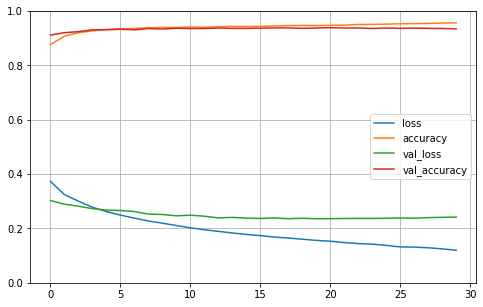

**Evaluation and Prediction**

93/93 [==============================] - 0s 2ms/step - loss: 0.2515 - accuracy: 0.9294

Loss: 25.15%
Accuracy: 92.94%


**Metric Scores**

Accuracy: 92.94%
Precision: 93.61%
Recall: 99.21%
F1: 96.33%

Confusion Matrix:
[[  10  188]
 [  22 2756]]


**Confusion Matrix**

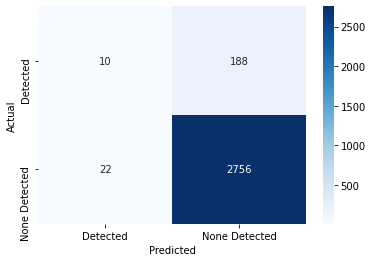

### Model 2 – Sequential: Dense Layers, ReLU Activation

**Summary**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 35)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 216       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
Total params: 1,490
Trainable params: 1,490
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

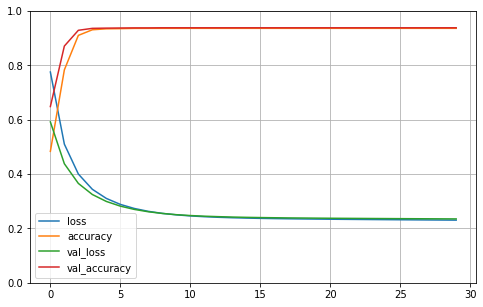

**Evaluation and Prediction**

93/93 [==============================] - 0s 1ms/step - loss: 0.2416 - accuracy: 0.9335

Loss: 24.16%
Accuracy: 93.35%


**Metric Scores**

Accuracy: 93.35%
Precision: 93.35%
Recall: 100.00%
F1: 96.56%

Confusion Matrix:
[[   0  198]
 [   0 2778]]


**Confusion Matrix**

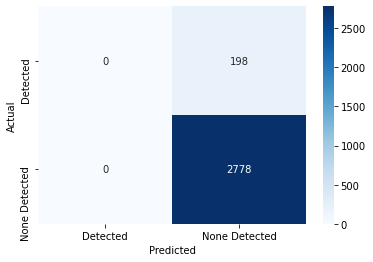

### Model 3 – Sequential: Dense Layers, PReLU Activation

**Summary**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 35)                1260      
_________________________________________________________________
p_re_lu (PReLU)              (None, 35)                35        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 216       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 6)                 6         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 14        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

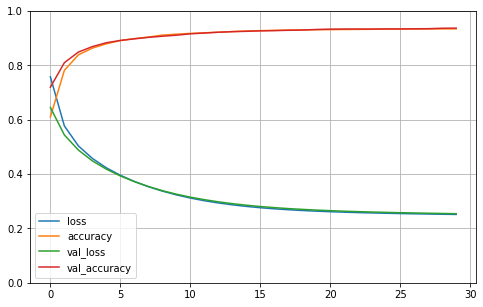

**Evaluation and Prediction**

93/93 [==============================] - 0s 2ms/step - loss: 0.2543 - accuracy: 0.9321

Loss: 25.43%
Accuracy: 93.21%


**Metric Scores**

Accuracy: 93.21%
Precision: 93.37%
Recall: 99.82%
F1: 96.49%

Confusion Matrix:
[[   1  197]
 [   5 2773]]


**Confusion Matrix**

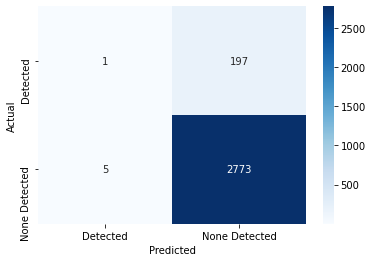

In [79]:
test_models(model_lst, (X_train2, y_train2, X_test2, y_test2))